In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import itertools as it

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

In [2]:
with open('new_5_all_results.pkl', 'rb') as f:
    all_results = pickle.load(f)

bptf_df = pd.read_pickle('bptf_matrix_results_df.pkl')

In [39]:
all_results['GDELT-F']['pgds'].keys()

dict_keys(['MAE', 'MAE-Z', 'MAE-NZ', 'MRE', 'MRE-Z', 'MRE-NZ', 'RMSE', 'RMSE-Z', 'RMSE-NZ', 'PERP', 'PERP-Z', 'PERP-NZ'])

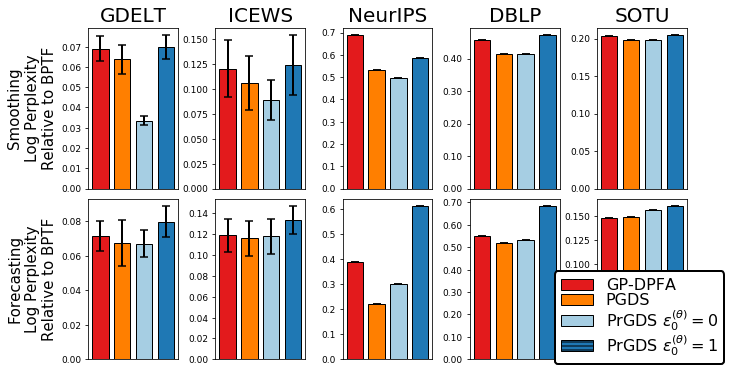

In [21]:

PGDS_COLOR = sns.color_palette("Paired")[7]
GPDPFA_COLOR = sns.color_palette("Paired")[5]
BPTF_COLOR = sns.color_palette("Paired")[10]
PRGDS0_COLOR = sns.color_palette("Paired")[0]
PRGDS1_COLOR = sns.color_palette("Paired")[1]

tPlot, axes = plt.subplots(nrows=2,
                           ncols=6, 
                           sharex=True, 
                           gridspec_kw={'height_ratios': [1,1],
                                        'width_ratios': [1,1,1,1,1,0.01]},
                           figsize=(10,5))


plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=0.1, hspace=0.1)

err_metric = 'PERP'
for row, task in enumerate(['Smoothing', 'Forecasting']):
    for col, data in enumerate(['GDELT', 'ICEWS', 'NIPS', 'DBLP', 'SOTU']):
        dataset = data + '-S' if task == 'Smoothing' else data + '-F'
        
        ax = axes[row][col]
        
        width=0.5
        space=width/3.
        
        data_str = data.lower() if data != 'SOTU' else 'stou'
        foo = bptf_df.loc[(bptf_df['model_type'] == 'bptf') & 
                          (bptf_df.experiment.apply(lambda x: data_str in x))]
        metric_str = 'perp_s_nz' if task ==  'Smoothing' else 'perp_f_nz'
        bptf_vals = np.array([np.log(x) for x in foo[metric_str]])

        vals = np.asarray(all_results[dataset]['pgds'][err_metric])
        vals = np.log(vals) / bptf_vals
        
        ax.bar(width + space, vals.mean(), yerr=vals.std(), label='PGDS', 
               color=PGDS_COLOR, width=width,
               error_kw=dict(lw=2, capsize=4, capthick=1.5),
               edgecolor='k')

        vals = np.asarray(all_results[dataset]['gpdpfa'][err_metric])
        vals = np.log(vals) / bptf_vals

        ax.bar(0, vals.mean(), yerr=vals.std(), label='GP-DPFA', 
               color=GPDPFA_COLOR, width=width,
               error_kw=dict(lw=2, capsize=4, capthick=1.5),
               edgecolor='k')

        xtick = 2 * (width + space)
        xticklabels = []
        blue_cmap = sns.color_palette("Blues", 8)
        purp_cmap = sns.color_palette("Greens", 8)
        
        for theta_eps, nu_eps, mtx_is_dirichlet in it.product([0,1],[1],[True]):
            prior = 'dir' if mtx_is_dirichlet else 'gam'
            model = 'v2-%s-theta%d-nu%d' % (prior, theta_eps, nu_eps)
            vals = np.asarray(all_results[dataset][model][err_metric])
            vals = np.log(vals) / bptf_vals
            
            color = PRGDS0_COLOR if theta_eps == 0 else PRGDS1_COLOR

            label ='PrGDS: $\\epsilon^{(\\theta)}{=}%d$, '% theta_eps
            label +='$\\epsilon^{(\\eta)}{=}%d$, '% nu_eps
            label += 'Dir' if mtx_is_dirichlet else '$\Gamma$' 
            ax.bar(xtick, vals.mean(), yerr=vals.std(), label=label, 
                   color=color, width=width,
                  error_kw=dict(lw=2, capsize=4, capthick=1.5),
                  edgecolor='k')
            xtick += width + space
            xticklabels.append(label)
        
        if col == 0:
            if row == 0:
                ax.set_ylabel('Smoothing\nLog Perplexity\nRelative to BPTF', fontsize=15)
            else:
                ax.set_ylabel('Forecasting\nLog Perplexity\nRelative to BPTF', fontsize=15)
            
        
        if row == 0:
            title = data
            if title == 'gdelt':
                title = 'GDELT'
            elif title == 'icews':
                title = 'ICEWS'
            elif title == 'monkeybrains':
                title = 'Macaque brains'
            elif title == 'NIPS' or title == 'nips':
                title = 'NeurIPS'
            ax.set_title(title, fontsize=20)
        
        if col == 3:
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.set_xticks(())
        ax.set_xticklabels(())
        ax.tick_params(axis='both', which='major', labelsize=9)
        
        ax.set_aspect('auto')

for row in range(2):
    ax = axes[row][5]
    ax.set_xticks(())
    ax.set_yticks(())
    ax.axis('off')

LEGEND_ELEMENTS = [mpatches.Patch(facecolor=GPDPFA_COLOR, 
                   edgecolor='Black', 
                   label='GP-DPFA'),
    
                mpatches.Patch(facecolor=PGDS_COLOR, 
                   edgecolor='Black', 
                   label='PGDS'),
                
                   mpatches.Patch(facecolor=PRGDS0_COLOR,
                    edgecolor='Black', 
                    label='PrGDS $\\epsilon_0^{(\\theta)}{=}0$'),

                  mpatches.Patch(facecolor=PRGDS1_COLOR, 
                    edgecolor='Black', 
                    hatch='-' * 3, 
                    label='PrGDS $\\epsilon_0^{(\\theta)}{=}1$')]

legend = plt.figlegend(handles=LEGEND_ELEMENTS,
              loc='lower right', 
              ncol=1,
              labelspacing=0.,
              framealpha=1.0,
              prop={'size':16},
              frameon=True)
legend.get_frame().set_linewidth(2)
legend.get_frame().set_edgecolor('Black')

plt.tight_layout(pad=0.1, h_pad=None, w_pad=None, rect=None)
plt.savefig('test_new_matrix_results.pdf',
            dpi=100, 
            pad_inches=0.0, 
            format='pdf')


In [18]:
-np.log(all_results[dataset]['gpdpfa']['PERP']), -np.log(all_results[dataset]['pgds']['PERP'])

(array([-0.43833235]), array([-0.44272942]))